In [2]:
import pandas as pd 
import sys
sys.path += ["../src"]
sys.path += ["../src/geonameslocator"]
import geolocator
import json
from glob import glob
import numpy as np
import climact_utils as cu
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp

In [3]:
import spark_init
from pyspark.sql import SQLContext

sc = spark_init.spark_context()
sqlContext = SQLContext(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/opt/spark//python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
file = sorted(glob(cu.data_path + "*after*/*"))[0]
    
path_name = cu.data_path + f"parent_id_after_strong/{file.replace('.', '/').split('/')[-2]}.npy"
pid = sqlContext.read.parquet(file).select("parent_id").distinct().toPandas()["parent_id"]


### Add non spaced words to location data

In [4]:
with open('../src/geonameslocator/locdictionary.json') as f:
    locdictionary = json.load(f)

In [5]:
locationdata = pd.read_csv("../src/geonameslocator/countriesdatap.tsv", sep='\t', low_memory=False, index_col="geonameid")

In [6]:
us_and_popular_id = locationdata.query("(population > 100000)|((countrycode == 'US')&(featurecode == 'ADM1'))").index

In [7]:
tokenized_names = [geolocator.find_names(name) for name in list(locationdata.loc[us_and_popular_id, "name"])]

In [48]:
new_json = {}
for set_u in tokenized_names:
    for u in set_u:
        if u in locdictionary.keys():
            split_u = u.split(" ")
            if len(split_u) > 0:
                new_json["".join(split_u)] = locdictionary[u]
                # locdictionary.update({"".join(split_u): locdictionary[u]})

In [49]:
locdictionary.update(new_json)

In [51]:
with open ('../src/geonameslocator/locdictionary.json', 'w') as f:
    json.dump(locdictionary, f)

In [8]:
geolocator.locationdata.loc[geolocator.find_best_match("newjersey")]

name                                                       New Jersey
asciiname                                                  New Jersey
alternatenames      ['New Jersey', 'Cene Dzhersi', 'Garden State',...
latitude                                                     40.16706
longitude                                                   -74.49987
featureclass                                                        A
featurecode                                                      ADM1
countrycode                                                        US
cc2                                                               NaN
admin1code                                                         NJ
admin2code                                                        NaN
admin3code                                                        NaN
admin4code                                                        NaN
population                                                    8751436
elevation           

### Count geolocations

In [2]:
import spark_init
sc = spark_init.spark_context()

def resilient_json(s):
    try:
        return json.loads(s)
    except:
        return {}
    

data_path = "/data/big/xxx/climact/data/"

columns = ['author',
 'subreddit',
 'body',
 'created_utc',
 'id',
 'link_id',
 'score',
 'subreddit_id',
 'parent_id']


utc_to_date = lambda x: pd.to_datetime(x["created_utc"], unit = "s")

bot_list=list(pd.read_csv(data_path + 'bot_list.csv')['author'])

activation_types = ["strong", "weak"]
type_texts = ["submissions", "comments"]
type_txts = ["RS", "RC"]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
sc.addPyFile("../src/geonameslocator/geolocator.py")

In [4]:
def exist_geolocation(s):
    exist = geolocator.find_best_match(s) is not None
    return exist

In [5]:
df_geo = pd.DataFrame(sc.textFile(cu.data_path + "history_strong_authors/RS_2016_09/*bz2").map(lambda x: resilient_json(x)).collect(), columns = cu.columns).dropna(subset = "subreddit")\
                    .assign(geolocation = lambda x: [geolocator.find_best_match(u) for u in x["subreddit"]]).dropna(subset = "geolocation")[["author", "subreddit", "geolocation"]].value_counts()

In [8]:
pd.read_csv(cu.data_path + "geolocated_comments_users_subreddit/strong_RS_2013_03.csv")

,author,subreddit,geolocation,count
0,TreeGrowsInBrooklyn,Republican,4514438.0,34
1,tonybeme,economy,5188236.0,30
2,wvoutpost,reddit.com,6542055.0,25
3,LawyersGunsAndMoney,China,1814991.0,16
4,LawyersGunsAndMoney,newjersey,5101760.0,14
...,...,...,...,...
64,tonybeme,tyson,5310183.0,1
65,JoeThankYou,China,1814991.0,1
66,EsotericMirror,Africa,2473572.0,1
67,JoeThankYou,gaming,7871899.0,1


### Remove mismatches

In [ ]:
mismatches = ["MMA","DIY","AMA", "rage","civ", "scifi","guns", "CFB", "Pure", "google", "Liberal", "RaIn", "pol", "police", "Republican", "Jung","dogs", "cars", "homestead", "wow", "Battlefield", "economy", "DnD", "energy","Ubuntu", "firefly","test","Kanye", "Hunting", "ios", "Green", "vita","GFD",
       "gif", "Vive","Drama","Cricket","ADHD", "Diablo","Coffee","batman","disney","de",
       "ass", "ARK", "EDM", "zen", "gis", "snowden", "Amd", "Metal","gwent","MTB","manga", "Sherlock","hacking","Canning","btc","nova","pens", "tall","Vue","mlb","CCW","DMT","SQL","kotor", "BSG","Naruto", "tea", "happy", "arduino","SCP","Spanish","Gotham","scala","MRW","cactus","PKA","McDonalds","git",
       "Anger","amazon","boulder", "gay","Bass","Equality","analog","turn","ramen","OSU", "FIFA", "SWORDS", "dune", "whitewater","STO", "Cascadia", "EBEs","Velo", "kings", "bigfoot", "Columbus","see","Cisco","lol", "army", "sto","beta", "wex", "ask", "homeland", "MtF", "YMS", "camping", "MLS", "soma",
       "kodi","VPN", "Vent", "rap", "law", "coys", "short", "osx", "TZM","Steep","swift","moab","christmas","arma","Walker", "wec","hbo","luke","SWN", "Portal","FRC", "redstone","Zappa", "KeyWest","lazy","GNV", "Pandora", "kotk", "Bernie","mmo", "mead", "fireworks", "Dell",
       "hydro", "ATT", "plano", "UCI", "Ferrari", "Sissy","live", "Sake","gog","blender", "rct","pepe","Lawrence","Honda","MRA","college","sad","magi", "PSP","brass", "Snek", "MMJ", "POF", "canon","drone","mensa", "hum", "pasta","funk","botany","Bamboo","folk","java",
       "Koans", "vine", "ASU", "Incel", "bose", "TARS", "Ultima","anno", "Brush", "gba","brush", "Durango", "Polit", "Bend","Browns","Toyota","kik","ems","vice","elm", "poop", "bernie","rva","demons","kingkong","basset","AZURE", "ISS","IBM", "Bellingham", "eu", "Cosmos",
       "piano", "USC", "wedding","Grimes", "Everest", "PHP", "GLI", "Constitution","TWD", "rem", "rum", "French", "Africa", "max", "weed", "lupus", "Nissan","PBS", "CMH","bach", "ames","svg","latin","SoSE", "dgu","kol", "horn","Catan","rush", "led", "matt","cnn", "Mustang","ted",'Candida','CoonTown','Viking', 'ting',
       "llama", "kitchener", "jmu", "Palestine", "Eve", "nfl", "gaming", "tifu", "Art", "war", "startup",'fsm', 'Quantico', 'obama','moba', 'ech','Fukushima', 'VPS','sales','peeling','Acme',
       'TCU', 'Dance', 'Staples', 'meta', 'Braunschweig', 'nook','TOR', 'gossip','JMT', 'NIU','NPD', 'Pets', 'TNG','Michael', 'psx',
       'SEO', 'excel','Barca','GRE', 'Rapids','labor', 'Saints','Kappa', 'redhead','Harley', 'golf', 'BBW', 'paragon', 'NEO','RWBY', 'Sat', 'Contest',  'sunset', 'yuri', 'bjj', 'nin',  'bois', 'sph','Maya', 'hmm', 'mfm', 'WRX','EDH', 'Emo', 'DOG', 'orioles', 'trap', 'Chihuahua','ACT', 'Hue', 'Target',  'MINI', 'Everton','ARG', 'Brewers', 'Draven', 'Supreme', 'Triumph', 'Vans','canes', 'mcgill', 'cade', 'oasis','eos', 'Ozark', 'FMN', 'cat', 'hammer', 'Coyotes', 'EHM','Coachella', 'css',  'vba', 'joi', 'mormon',  'Vore', 'lux', 'dxm', 'PAX', 'German','Sup', 'Bacon',  'tales', 'astoria', 'DarK','BBB',  'sabres', 'Broadway', 'liberta',
       'ColoradoSprings', 'psx''Astros', 'plants', 'SFM', 'dicks', 'UMD','pug', 'Lyme', 'Nokia', 'fonts',  'mwo','rust',  'bih',  'rat', 'doge',
       'CFD', 'jordan',  'NEU',  'tfc', 'Kos','PLC',  'Vivarium', 'fsu', 'Catahoula','dayton', 'baylor', 'Agos', 'MUN','bridge','reading', 'YMatA','Soto','gate','landmark', 'utc', 'SNL','und','bats', 'CLT', 'Billings', 'dtm','TNA','crouch','Aledo', 'telemark','kot', 'Iron', 'sas','Daniel','Defiance', 'luther','SCT',
       'MAME', 'marciel',  'lepin', 'crows', 'cky',       'davao', 'deadwood', 'dear', 'dev',  'Carcassonne', 'Celebration','Chinchina', 'Chucky', 'irl',  'jardin', 'jgb', 'jira','kakinada', 'kandi', 'caran', 'cayman',  'chili','chunky', 'cicada', 'cmd', 'cmu',  'Ibanez',
        'capoeira', 'car', 'kritika', 'ksi', 'labyrinth', 'lafayette',  'laredo', 'GodField', 'City', 'Collie','kosher',  'kot''midori', 'mii', 'mining',  'CME', 'CPA','transit','BDS','trans','sfc', 'milwaukee','Kava','dnc','SNP','TEFL','tiling','PEI', 'midi','chernobyl','bond', 'place', 'Nolan','fail'
       'mechanic', 'loss', 'maia',  'marbel','marines', 'Blades', 'Bong', 'Booze', 'conan','RiL', 'HGD', 'House','TBI','hsx', 'hsp','BSA', 'SEGA','tamil', 'irc', 'grimm','MTU','bash','byu', 'paint','ETE','GMO', 'Troy','Tavor',
        'Hitchcock', 'IGN', 'IST','pedale','Pitt', 'ebola', 'SRS','ben','media','restaurant', 'NOG', 'utopia', 'CBS', 'podio','PhD', 'poi','Wool','sims','ferguson','Gore', 'Pink', 'lds', 'raw','pressy','ANGEL', 'huty','BTS',  'candy',   'HGH','ula', 'MIne', 'Pee', 'hbt', 'Astros', 'UNU', 'Tanner', 'Nagato','latinas', 'lena','ACK', 'panda','Barbara', 'penguin', 'UCA', 'cum', 'cuse', 'tiger', 'slup','tongue',
       'MAA','Ryan', 'dam', 'Mars', 'Fun','Sumo', 'miran', 'tornado', 'Laina', 'tango', 'tsu','wft', 'mgw', 'TYT', 'silly', 'kense', 'hmb', 'gross','chen', 'ERB', 'banana', 'asia', 'STEM','HOLO',   'bulldog', 'bully', 'labrador',
       'aquarium',  'Lottery','Ishii', 'u_The-Oceans-Gay-Waves', 'nbn', 'lacrosse', 'Christian', 'haskell', 'DACA', 'karma',  'fea', 'Gin', 'Jindo', 'Celica', 'benfica','besiktas', 'tron','twilight', 'rance', 'akita', 'Shen','arcade', 'asl', 'Salvia', 'KTM',  'SBU',  'marton', 'logh', 'BoBoLA',  'slp','Home', 'msp',  'Concordia', 'Concrete',
       'Cow',  'flint', 'Eustis', 'Viola','Brentford', 'Bryce',  'mercedes', 'Lain','Lamia',  'Trombone', 'UGA', 'tequila','sesame', 'cognac', 'corpus', 'chivas', 'chocolate', 'abv','Lubbock', 'wood', 'cfs', 'ruby',  'Koi','bch', 'triangle', 'GED', 'kof', 'blackjack', 'dolan', 'Cardiff','aurora', 'KSU',  'Kawasaki',  'Ska',
       'SLO', 'SPG', 'perl', 'api',  'Dimon', 'evergreen','fivehead',  'PSW', 'enf', 'Pohja', 'Queens','ski',  'cafe', 'Pontiac', 'Pristin', 'QRL', 'PRINCE',  'ALS',  'psg', 'patreon', 'Juniper', 'banjo','Irma', 'JWs',  'avb', 'apollo', 'pagan','opera', 'orange', 'osr', 'ota', 'ATC','bronco', 'bim', 'beg',  'Khan', 'ropes',  'amv', 'anchorage', 'MBA',
       'smart', 'saw', 'santa','Wake',  'murakami',  'Hulu', 'IOT','BELGICA',  'mobile', 'momo', 'mets','Cadillac', 'Tivo', 'Toes', 'Tree', 'Tegu', 'Temple', 'Suomi','shine',  'CISA', 'mahwah', 'lua', 'clans',  'lean', 'vtl','virgin',  'u_sexual-sinning', 'knolling','Font', 'Forth', 'delta', 'dnp', 'docker', 
       'Citra', 'Monsanto', 'Siri',  'Orania', 'Orton','SALEM', 'SAP', 'Rime', 'Cebu', 'Diamond',  'DOTA',  'Panorama','Papa',  'Pecs', 'Outlook','PAPU', 'Salsa',  'Ebony', 'Pain', 'gun','hemp','frl', 'gibson', 'gill', 'gorn',  'gtd', 'Elkhart','Emmen',  'Erie',  'cults', 'ECG', 'Commodore', 'Covina',
       'ENGLISH',  'Dobro', 'ichu', 'illuminati', 'edmundston', 'elo', 'esa', 'fanshawe', 'DSM', 'DYR', 'Gold', 'dui', 'DECA', 'DMB', 'dns', 'Fairbanks', 'Fez',  'Fude',  'Gemini', 'crv', 'crx', 'dad','dase''maille',  'Bear', 'RBA','orks', 'Converse', 'Cornell', 'Hamilton', 'Fedora','SkyLine', 'pigeon', 'Bowling','MoonCoin', 'ico', 'GAA', 'wls', 'butts', 'bourbon', 'Dodge',
       'Drag', 'greenville', 'Brompton', 'Bier','duck', 'msu', 'OCD', 'ATV', 'SKS''labrador',  'Kirby', 'zec', 'prey','CLG', 'hawks', 'ARAM','riddles', 'vim', 'cad', 'Sino', 'jav', 'Briggs',
       'bird', 'Stellar', 'agt',  'Ford','Kindred','HWYA','obs', 'Muse',  'Kingdom', 'Iota', 'cardano', 'cavaliers','nes',  'chinchilla', 'soles','Jibo','Madonna', 'gnu', 'SGU','sva', 'mit', 'wakarusa', 'maille','Comet','ion', 'Barber','Mike', 'GERD', 'hsv','byzantium','hab', 'KANOA', 'bismarck', 'Disco', 'GYM','cassandra','turku', 'ARL','Williamsport', 'Northwestern','indie']

good_matches = ['argentina', 'boston', 'unitedkingdom', 'northernireland', 'Miami','Denver', 'canada', 'saskatchewan', 'Thailand', 'Portland','Kamloops','Indiana', 'California', 'nyc', 'newzealand', 'Colorado', 'sydney',
       'australia', 'philadelphia', 'ottawa', 'melbourne', 'france','ireland', 'japan', 'chicago', 'indianapolis', 'Sacramento','Scotland', 'norge', 'Israel', 'london', 'StLouis', 
       'Atlanta', 'houston', 'Virginia', 'kurdistan', 'oklahoma','massachusetts', 'ontario', 'illinois', 'Cleveland', 'Quebec','sanfrancisco', 'orangecounty', 'arizona', 'texas', 'Calgary',
       'Turkey', 'Maine', 'vermont', 'newhampshire', 'york', 'india', 'China', 'alberta', 'sweden','saskatoon', 'fresno', 'galapagos', 'yorkshire', 'Austin','Denton', 'FortWorth', 'orlando', 'newyork', 'kansas',
       'Tennessee', 'brisbane', 'minnesota',  'Denmark','mexico',  'Malibu', 'germany','newcastle', 'Belfast', 'NovaScotia', 
       'Breckenridge', 'gloucester', 'newengland', 'NorthCarolina','PuertoRico', 'maryland', 'florida', 'Connecticut', 'Harvard','Iceland',  'spain', 'Charlotte','aves', 'penticton',  'phoenix', 'Detroit', 'goodnews',
        'Philippines',  'Kazakhstan','BuenosAires', 'Colombia',  'iran', 'Brooklyn','russia', 'sandiego',  'VirginiaBeach','cincinnati', 'Hawaii', 'Seattle', 'Michigan', 'SaltLakeCity',
       'Naperville', 'yellowstone', 'wyoming','stanford', 'berkeley', 'forge', 'newjersey', 'vancouver','latvia', 'Norway', 'Kentucky', 'Ohio', 'LosAngeles', 'providence', 'Edmonton', 'shreveport', 'okc',
       'montreal', 'Acadiana', 'oregon', 'WestVirginia', 'Louisiana','indonesia', 'capetown', 'HongKong', 'Adelaide', 'Iowa', 'Alabama','baltimore', 'deutschland', 'Dallas', 'auckland', 
       'northdakota', 'toronto', 'lincoln', 'tampa', 'Pennsylvania','korea', 'bangalore', 'Charlottesville', 'abbotsford', 'usa','ElPaso', 'pittsburgh', 'Syria', 'McKinney', 'maui', 'brussels','Utah', 'NewOrleans', 'frankfurt', 'Rochester', 'greece',
       'belgium', 'columbia', 'missouri', 'copenhagen', 'desmoines','kelowna', 'Eugene', 'ukraine', 'Reno', 'Kenya', 'Kerala','portugal', 'Brazil', 'Nicaragua', 'riodejaneiro', 'Aleppo', 'Washington','singapore', 'Georgia', 'bali', 'sanantonio', 'vegas', 'Tiburon',
       'SantaFe', 'dubai', 'Cheyenne', 'italy', 'halifax', 'Polska', 'Peterborough', 'batonrouge','britishcolumbia', 'Tacoma', 'azores',  'Rhodesia',
       'greensburg', 'fredericton', 'Amsterdam', 'johnstown', 'memphis','NewcastleUponTyne', 'Albany', 'Bahrain', 'nashville', 'oslo','princeton', 'sanmarcos', 'Prague', 'clarkson', 'Letterkenny','bahamas', 'Wales', 'guam',  'longbeach', 'Nevada',
       'Omaha', 'Syracuse', 'Dublin', 'lynchburg', 'galway', 'canberra', 'Rolla', 'Tuebingen','bloomington', 'auburn', 'jerseycity', 'toledo','Montana',  'brasil', 'chile', 'serbia','Athens','malaysia', 'norfolk','perth', 'Winnipeg', 'kansascity', 'ukraina','Minneapolis','paris',
       'hungary','Brunei', 'Nepal', 'Sverige', 'Charleston', 'longisland', 'grandrapids', 'VietNam','manchester','Austria', 'Louisville', 'poland','raleigh', 'Slovenia','statenisland', 'SantaBarbara','bulgaria',  'uruguay','riverdale','lebanon','tulsa', 'Egypt','Edinburgh','Tokyo','lexington','Birmingham', 'Wellington', 'Barcelona', 'Spokane', 'SanJose', 'glasgow','mumbai', 'Tucson', 'fargo','Arkansas', 'Knoxville', 
       'Eesti','jacksonville', 'Finland','asheville', 'saudiarabia','Honolulu','FortCollins', 'Chattanooga', 'wien','SouthBend',  'Wolfenstein','albania','mississauga', 'Wilmington','Buffalo', 'berlin','lithuania', 'alaska', 'RhodeIsland','newfoundland',    'Delaware', 'santarosa',  'shanghai', 'olympia','Pensacola','Kuwait','santacruz','Sakartvelo', 'waterloo', 'wichita','evansville','brighton','stockholm','manhattan',
       'tijuana', 'Dexter','roanoke','moncton', 'mongolia', 'Brest', 'Broward','newhampton',  'Morocco','armenia', 'wisconsin', 'zurich','plattsburgh','qatar','cedarrapids', 'Boise','Brampton', 'Tempe', 'Utrecht',
       'Bakersfield', 'hrvatska','hobart','brum','Liverpool','Tallahassee', 'Bozeman','cambodia', 'Gothenburg', 'duluth',
       'pakistan','Madrid','firenze', 'hamburg','dundee', 'NewMexico','Somalia','Oahu','Harrisburg','LasVegas' ,'dunedin', 'guatemala'
       'cologne', 'PacificNorthwest','graz', 'guangzhou','frisco', 'galveston', 'Essex','fortwayne','Logan', 'LittleRock', 'Kotlin','VancouverIsland', 'Libya',
       'newhaven', 'newtown','Hoboken','cambridge','mississippi','minot','tasmania', 'southcarolina', 'srilanka','burbank', 'burma'
       'PERU','Jamaica', 'pasadena','oakland', 'Annapolis', 'beaverton','Kenosha','Kochen','regina', 'rome','algeria', 'sarasota', 'Lethbridge','Tianjin','sheffield','catalonia', 'catalunya','savannah','chapelhill', 'laos','venice', 'venturacounty','Mosses', 'Sondheim',
       'Southampton', 'lakeland','Genova','Slovakia','cuba','Nebraska', 'Newbridge', 'Rotterdam','Osaka','Drexel','Wiesbaden','Panama','Parkdale', 'Pearland', 'Owasso','Owensboro','hanoi', 'harrisonburg', 'hattiesburg', 'helsinki','hillsboro', 'freiburg''greenland','Enumclaw','fortlauderdale','fayetteville','Dalhousie', 'Danbury','duke', 'huddersfield','Dunkirk', 'huntingtonbeach','Guelph', 'Gujarati',
       'Flagstaff','karlsruhe', 'kauai','Campbellton', 'Chengdu','irvine','leicester', 'ITAGLIA','krakow','Hannover', 'Hartford', 'Heidelberg','lakewood', 'Clemson','lancaster','kosovo','missoula', 'moana', 'moldova','croatia', 'linkoping', 'lisboa', 'livonia', 'longmire',
        'corvallis', 'menorca', 'Cairns','Hagen','buda','Albuquerque', 'niagara', 'ithaca',  'bristol','Binghamton', 'Somerville', 'palmsprings', 'Manitoba', 'Fredonia', 'Geelong', 'Utica', 'Emory', 
       'nanaimo', 'Squamish',  'Sunnyvale',  'Idaho','Corning', 'Orillia',  'wayland',  'burnaby','coquitlam', 'Parksville', 'Sarnia','Invermere', 'Langley',  'bellevue', 'princegeorge','Tonawanda', 'Welland',  'Korn',  'PERU', 'cologne',
       'Iraq',  'AnnArbor',  'Poznan','fukuoka', 'Longmont', 'Hastings', 'Switzerland', 'Senegal',  'hertfordshire', 'evanston','mountainview', 'Pyongyang', 'ghana',  'Temecula', 'Winchester', 'saintcloud',  'Samoa', 'Romania', 'taiwan', 'cyprus', 'fiji', 'glacier'
       'Sudbury',  'Brickton', 'Burnley',  'Chennai', 'seoul', 'burlington',       'Transnistria',  'Zwolle', 'nottingham', 'clearlake',       'stuttgart',  'istanbul', 'notredame',
       'Rockwall', 'basel', 'Ethiopia', 'Munich', 'pueblo', 'akron', 'colony',  'Leiden',  'Norwich','lansing', 'Gwinnett', 'Honesdale', 'bronx', 'ballarat',  'Constantine', 'cork',  'ecuador', 'Aberdeen', 'bangladesh',   'murfreesboro', 'beijing', 'greenland','barrie',  'Whistler',  'odense', 'lucknow',  'cymru','shenzhen',  'okinawa', 'Helix',  'amarillo', 'montgomery', 'Leeds', 'maastricht','macedonia', 'Salisbury', 'ventura', 'SiouxFalls', 'oxford',   'Leuven',
       'Aarhus', 'wroclaw', 'Waltham', 'Lyon', 'Bangkok', 'fredericksburg',
       'Netherlands',  'thousandoaks', 'Convoy',
       'SouthDakota', 'Westchester', 
       'Luxembourg',  'glendale', 'Humboldt', 
        'SantaMaria',  'Worcester',
       'nashua', 'tuscaloosa', 
       'england',  'Issaquah', 
        'dresden', 'guatemala',
       'Yellowknife', 'Campbell', 'Hosting', 
       ]


# len(geolocations_strong.query("subreddit not in @mismatches")["author"].unique())

In [7]:
# sorted(glob(cu.data_path + "author_strong_activation_date"))
these_months = np.arange(1,13)
year = 2016
len(pd.read_csv(cu.data_path + "author_weak_activation_date.csv").query("(year == @year)&(month in @these_months)"))

110123

In [8]:
geolocations_strong = pd.concat([pd.read_csv(cu.data_path + f"geolocated_comments_users_subreddit/weak_RC_{year}_{(month):02d}.csv") for month in these_months]).assign(mismatch = lambda x: [u in mismatches for u in x["subreddit"]], good_match = lambda x: [u in good_matches for u in x["subreddit"]])
all_authors = pd.concat([pd.read_csv(cu.data_path + f"geolocated_comments_users_subreddit/weak_RC_{year}_{(month):02d}.csv") for month in these_months])

In [9]:
geolocations_strong[["mismatch", "good_match"]].sum()

mismatch      213586
good_match     84700
dtype: int64

In [10]:
print("Proportion of labelled subreddit", len(geolocations_strong.query("good_match|mismatch").subreddit.unique()) / len(geolocations_strong.subreddit.unique()))
print("Proportion of labelled authors", len(geolocations_strong.query("good_match|mismatch").author.unique()) / len(geolocations_strong.author.unique()))

Proportion of labelled subreddit 0.3905044510385757
Proportion of labelled authors 0.9963825428519565


In [11]:
print("Proportion of users with at least one good location")
len(geolocations_strong.query("good_match").author.unique()) / len(pd.read_csv(cu.data_path + "author_strong_activation_date.csv").query("(year == @year)&(month in @these_months)"))

Proportion of users with at least one good location


29.340862422997947

In [13]:
# with open(cu.data_path + "good_matches_subreddit_ceolocation.txt", "w") as f:
#     for subreddit in good_matches:
#         f.write(subreddit + "\n")

# with open(cu.data_path + "bad_matches_subreddit_ceolocation.txt", "w") as f:
#     for subreddit in mismatches:
#         f.write(subreddit + "\n")


In [14]:
read_good_matches = []

with open(cu.data_path + "good_matches_subreddit_ceolocation.txt", "r") as f:
    for l in f.readlines():
        read_good_matches.append(l.rstrip("\n"))


read_bad_matches = []

with open(cu.data_path + "bad_matches_subreddit_ceolocation.txt", "r") as f:
    for l in f.readlines():
        read_bad_matches.append(l.rstrip("\n"))


In [15]:
print("geolocated subreddit", len(read_good_matches))

geolocated subreddit 567


In [16]:
# geolocated_authors = geolocations_strong.query("subreddit not in @mismatches")["author"].unique()
geolocated_subreddit = geolocations_strong.query("~(mismatch|good_match)").subreddit.unique()

In [17]:
geolocated_subreddit[:50]

array(['titanic', 'NAU', 'Imperial', 'Paul', 'Destin', 'kendo',
       'arlington', 'Tyr', 'Gaithersburg', 'RoundRock', 'Julia', 'Sierra',
       'huntersville', 'porto', 'fail', 'Hindi', 'Darmstadt',
       'stephenville', 'wollongong', 'David', 'Vasteras', 'yale',
       'Holden', 'haiti', 'Moscow', 'dci', 'gso', 'alpharetta', 'vala',
       'SantaClarita', 'Democrat', 'TAS', 'geneva', 'gary', 'Malawi',
       'LPC', 'eindhoven', 'Towson', 'uppsala', 'DEG', 'chico', 'Blue',
       'Kirkland', 'Montevallo', 'kerry', 'ferret', 'Lincolnshire',
       'arab', 'Artemis', 'Oman'], dtype=object)

In [18]:
geolocator.locationdata.loc[geolocator.find_best_match("Troy NY")]

name                                                             Troy
asciiname                                                        Troy
alternatenames      ['Troy', 'Ashleys Ferry', 'Ferry Hook', 'Traj'...
latitude                                                     42.72841
longitude                                                   -73.69179
featureclass                                                        P
featurecode                                                     PPLA2
countrycode                                                        US
cc2                                                               NaN
admin1code                                                         NY
admin2code                                                        083
admin3code                                                    75484.0
admin4code                                                        NaN
population                                                      49906
elevation           

In [19]:
good_geolocations = geolocations_strong.query("good_match").assign(countrycode = lambda x: [geolocator.locationdata.loc[u].countrycode for u in x["geolocation"]], admin1code = lambda x: [geolocator.locationdata.loc[u].admin1code for u in x["geolocation"]])

In [24]:
one_country_authors = list(good_geolocations.groupby(["author", "countrycode"]).count().reset_index()["author"].value_counts().reset_index().query("count == 1")["author"])
one_admin = list(good_geolocations.groupby(["author", "countrycode", "admin1code"]).count().reset_index()["author"].value_counts().reset_index().query("count == 1")["author"])

In [17]:
print("Proportion of authors that wrote in a single country (among all authors)", len(one_country_authors) / len(pd.read_csv(cu.data_path + "author_strong_activation_date.csv").query("(year == @year)&(month in @these_months)")))
print("Proportion of authors that wrote in a single admin (among all authors)", len(one_admin) / len(pd.read_csv(cu.data_path + "author_strong_activation_date.csv").query("(year == @year)&(month in @these_months)")))


Proportion of authors that wrote in a single country (among all authors) 21.636550308008214
Proportion of authors that wrote in a single admin (among all authors) 16.87337440109514


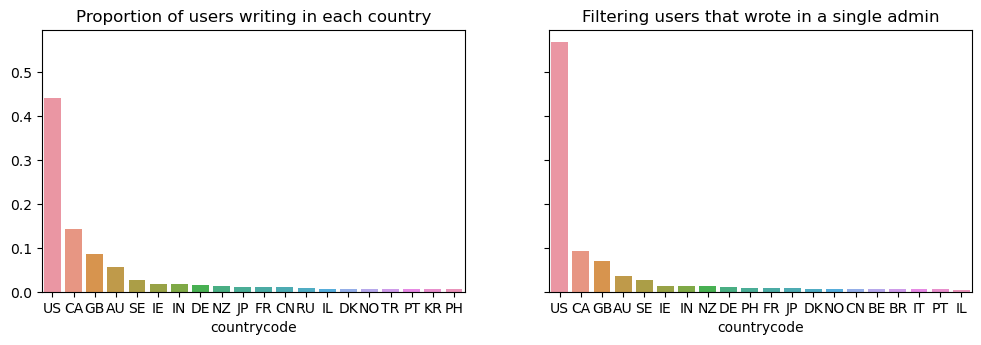

In [18]:
fig, axes = sbp(ncols = 2, figsize = (12, 3.4), sharey = True)
sns.barplot(data = (good_geolocations["countrycode"].value_counts() / good_geolocations["countrycode"].value_counts().sum())[:20].reset_index(), x = "countrycode", y = "count", ax = axes[0])
sns.barplot(data = (good_geolocations.query("author in @one_admin")["countrycode"].value_counts() / good_geolocations.query("author in @one_admin")["countrycode"].value_counts().sum())[:20].reset_index(), x = "countrycode", y = "count", ax = axes[1])

axes[0].set_title("Proportion of users writing in each country")
axes[1].set_title("Filtering users that wrote in a single admin")
axes[0].set_ylabel("")
axes[1].set_ylabel("")
fig.show()

In [19]:
(good_geolocations.query("author in @one_admin")["countrycode"].value_counts() / good_geolocations.query("author in @one_admin")["countrycode"].value_counts().sum())[:7]

countrycode
US    0.566874
CA    0.093551
GB    0.068780
AU    0.036534
SE    0.027483
IE    0.013631
IN    0.013448
Name: count, dtype: float64

In [20]:
good_geolocations.query("countrycode == 'CA'")[["subreddit", "admin1code"]].value_counts()

subreddit        admin1code
canada           0.0           5588
toronto          8.0           1384
vancouver        2.0            830
Calgary          1.0            654
ontario          8.0            453
alberta          1.0            426
ottawa           8.0            404
Edmonton         1.0            397
montreal         10.0           308
Winnipeg         3.0            240
Quebec           10.0           206
halifax          7.0            198
britishcolumbia  2.0            178
saskatoon        11.0           127
saskatchewan     11.0            97
mississauga      8.0             66
newfoundland     5.0             62
Brampton         8.0             60
NovaScotia       7.0             57
regina           11.0            56
kelowna          2.0             48
Guelph           8.0             37
Manitoba         3.0             35
moncton          4.0             26
fredericton      4.0             22
nanaimo          2.0             21
barrie           8.0             18


In [35]:
geolocator.locationdata.loc[geolocator.find_best_match("Manitoba")][5:], geolocator.locationdata.loc[geolocator.find_best_match("winnipeg")][5:]

(featureclass                       A
 featurecode                     ADM1
 countrycode                       CA
 cc2                              NaN
 admin1code                       3.0
 admin2code                       NaN
 admin3code                       NaN
 admin4code                       NaN
 population                   1193566
 elevation                        NaN
 dem                              204
 timezone            America/Winnipeg
 modificationdate          2019-12-20
 Name: 6065171, dtype: object,
 featureclass                       P
 featurecode                     PPLA
 countrycode                       CA
 cc2                              NaN
 admin1code                       3.0
 admin2code                       NaN
 admin3code                       NaN
 admin4code                       NaN
 population                    632063
 elevation                        NaN
 dem                              245
 timezone            America/Winnipeg
 modificationdate  

In [21]:
df_canada_provinces = pd.DataFrame([row.split('"')[:2] for row in pd.read_csv("/data/big/xxx/climact/data/canada_population_provinces.csv", header = 8, sep = ";", names = ["cols"])["cols"][:14]], columns = ["PROVINCE", "POPULATION"])
df_canada_provinces = df_canada_provinces.assign(PROVINCE = lambda x: [u[:-3] if "2" in u else u[:-1] for u in x["PROVINCE"]],
                           POPULATION = lambda x: [int("".join([k for k in u if k != ","])) for u in list(x["POPULATION"])])\
                            .merge(pd.DataFrame([{
                                'Newfoundland and Labrador':5,
                                'Nova Scotia':7,
                                'New Brunswick':4,
                                'Quebec': 10,
                                'Ontario':8,
                                'Manitoba':3,
                                'Saskatchewan':11,
                                'Alberta':1, 
                                'British Columbia':2,
                                'Northwest Territories':13}]).T.reset_index().rename(columns = {"index": "PROVINCE",0: "admin1code"}))

In [22]:
df_canada_provinces

,PROVINCE,POPULATION,admin1code
0,Newfoundland and Labrador,510550,5
1,Nova Scotia,969383,7
2,New Brunswick,775610,4
3,Quebec,8501833,10
4,Ontario,14223942,8
5,Manitoba,1342153,3
6,Saskatchewan,1132505,11
7,Alberta,4262635,1
8,British Columbia,5000879,2
9,Northwest Territories,41070,13


In [25]:
users_canada = good_geolocations.query("(author in @one_admin)&(countrycode == 'CA')").groupby(["author", "admin1code"]).first().reset_index().groupby("admin1code").sum()["good_match"].reset_index().rename(columns = {"good_match": "NUM_USERS"})
users_canada = users_canada.assign(admin1code = lambda x: [int(u[:-2]) for u in x["admin1code"]]).merge(df_canada_provinces)

In [27]:
import geopandas as gpd
import climact_utils as cu

In [28]:
excluded_admin = ['VI','MP','GU','AS','PR']
non_continental_admin = ['HI','AK']
us_shape = gpd.read_file(cu.data_path + "geo_data/tl_2023_us_state/tl_2023_us_state.shp").to_crs("EPSG:4326").query("STUSPS not in @excluded_admin").sort_values("STUSPS")
pop_data = pd.read_csv(cu.data_path + "geo_data/US_POPULATION_STATE.csv", sep = ";")[["State", "01/07/23"]].rename(columns = {"01/07/23": "Population"}).iloc[:51].assign(State = lambda x: [u[1:] for u in x["State"]], Population = lambda x: [int("".join(u.split("."))) for u in x["Population"]])

In [29]:
us_shape = us_shape.merge(good_geolocations.query("(author in @one_admin)&(countrycode == 'US')&(admin1code != '00')")["admin1code"].value_counts().reset_index().reset_index().rename(columns = {"admin1code": "STUSPS", "count": "NUM_USERS"}), how = "left")

In [30]:
us_shape = us_shape.merge(pop_data.rename(columns = {"Population": "POPULATION", "State": "NAME"}), how = "left")

<Axes: >

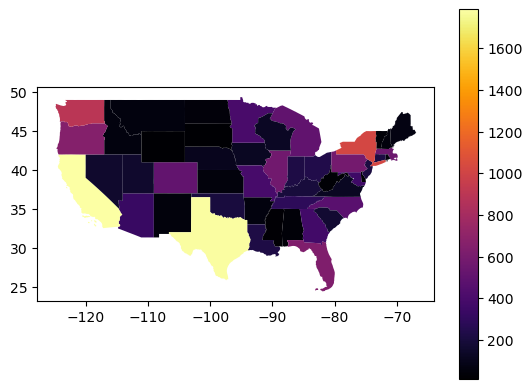

In [179]:
us_shape.query("STUSPS  not in @non_continental_admin").plot("NUM_USERS", legend = True, cmap = "inferno")

<Axes: >

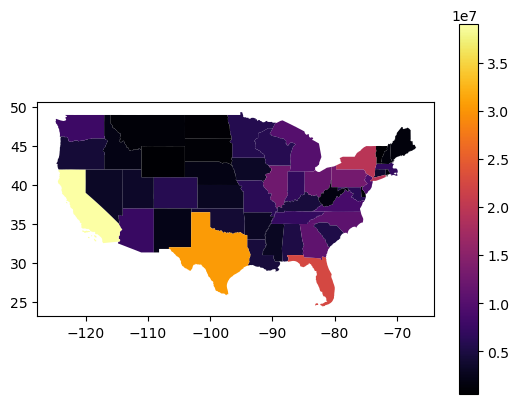

In [180]:
us_shape.query("STUSPS  not in @non_continental_admin").plot("POPULATION", legend = True, cmap = "inferno")

In [33]:
users_canada

,admin1code,NUM_USERS,PROVINCE,POPULATION
0,1,255,Alberta,4262635
1,10,92,Quebec,8501833
2,11,47,Saskatchewan,1132505
3,13,1,Northwest Territories,41070
4,2,187,British Columbia,5000879
5,3,45,Manitoba,1342153
6,4,11,New Brunswick,775610
7,5,11,Newfoundland and Labrador,510550
8,7,35,Nova Scotia,969383
9,8,412,Ontario,14223942


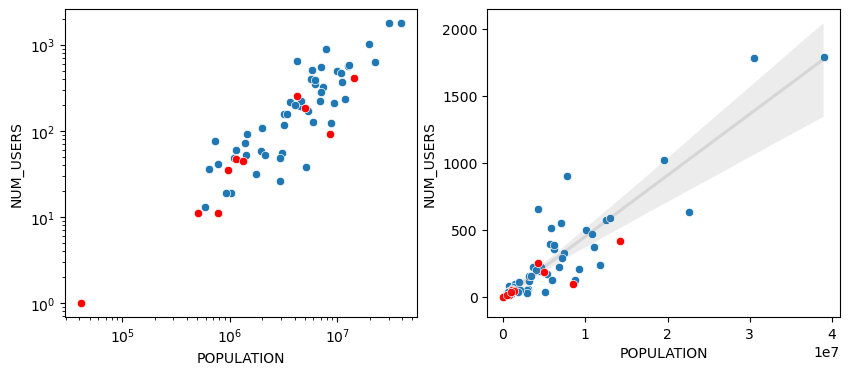

In [36]:
fig, axes = sbp(ncols = 2, figsize = (10, 4))
sns.scatterplot(data = us_shape, x = "POPULATION", y = "NUM_USERS", ax = axes[0])
sns.scatterplot(data = users_canada, x = "POPULATION", y = "NUM_USERS", color= "red", ax = axes[0])
sns.regplot(data = pd.concat([us_shape[["POPULATION","NUM_USERS"]].assign(COUNTRY = "US"), users_canada[["POPULATION","NUM_USERS"]].assign(COUNTRY = "CA")]), x = "POPULATION", y = "NUM_USERS", 
            ax = axes[1], scatter_kws = {"alpha": 0}, line_kws = {"alpha": 0.2, "color": "grey"})
sns.scatterplot(data = us_shape, x = "POPULATION", y = "NUM_USERS", ax = axes[1])
sns.scatterplot(data = users_canada, x = "POPULATION", y = "NUM_USERS", color= "red", ax = axes[1])
# sns.regplot(data = users_canada, x = "POPULATION", y = "NUM_USERS", color= "red", ax = axes[1])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
# axes[1].set_xscale("log")
# axes[1].set_yscale("log")


